# Влияние шума на PCA
---
## Цель эксперимента

Оценить, как добавление шума уровня
$$\sigma_{\text{noise}} = \text{noise\_level} \times \sigma$$
к исходным данным влияет на:

- **Долю объяснённой дисперсии** $\gamma$ первых $k$ компонент.
- **Среднеквадратическую ошибку восстановления** (MSE).

---
## Сравнение метрик до и после

In [55]:
import matplotlib.pyplot as plt
from src.Matrix import Matrix
from src.add_noise_and_compare import add_noise_and_compare
from sklearn.datasets import load_iris

In [56]:
iris = load_iris()
X_mat = Matrix([list(map(float,row)) for row in iris.data])
y = list(iris.target)

In [69]:
res = add_noise_and_compare(X_mat, noise_level=10)
k = res["k"]
print("Используем k =", k)
print("До шума: γ =", res["orig"]["gamma"], " MSE =", res["orig"]["mse"])
print("С шумом: γ =", res["noisy"]["gamma"], " MSE =", res["noisy"]["mse"])

Используем k = 2
До шума: γ = 0.9776851643103016  MSE = 0.025341076014157173
С шумом: γ = 0.8156137066106568  MSE = 18.972376553821164


---
### Доля объяснённой дисперсии $\gamma$

- **До шума** $\gamma_{\text{orig}} \approx 0.978$
  Первые две компоненты захватывают почти $97.8\%$ разброса данных → очень «скученная» структура, легко аппроксимируется в двумерном подпостранстве.

- **С шумом** $\gamma_{\text{noisy}} \approx 0.816$
  После добавления шума доля «полезного» сигнала падает до $81.6\%$.

Таким образом, аддитивный гауссов шум с дисперсией $\sigma_{\text{noise}}^2$ равномерно распределён по всем направлениям, т.е. к исходной ковариации $\Sigma$ прибавляется $\sigma_{\text{noise}}^2 I$. \
 В результате собственные значения сдвигаются вверх на $\sigma_{\text{noise}}^2$, но относительный вклад ведущих $\lambda_i$ снижается:

$$
\Sigma_{\text{noisy}} = \Sigma_{\text{orig}} + \sigma_{\text{noise}}^2 I,
\qquad
\gamma_{\text{noisy}} = \frac{\sum_{i=1}^k (\lambda_i + \sigma_{\text{noise}}^2)}{\sum_{i=1}^m (\lambda_i + \sigma_{\text{noise}}^2)} < \gamma_{\text{orig}}.
$$

---
### Среднеквадратическая ошибка восстановления (MSE)

- **До шума** $\mathrm{MSE}_{\mathrm{orig}} \approx 0.025$
  Очень малое значение, потому что мы почти полностью восстанавливаем данные в подпостранстве размерности 2.

- **С шумом** $\mathrm{MSE}_{\mathrm{noisy}} \approx 18.97$
  Ошибка выросла в тысячи раз. Поскольку шум с уровнем `noise_level = 10` означает добавление случайной величины с СКО $10\,\sigma_j$ к каждому признаку, его дисперсия $(10\,\sigma_j)^2 = 100\,\sigma_j^2$ доминирует в восстановлении:

$$
\mathrm{MSE} = \frac{1}{n m} \sum_{i,j} \bigl(X_{ij} - X_{\mathrm{rec},ij}\bigr)^2 \;\approx\; \text{доля шума} \;\sim\; \sigma_{\text{noise}}^2.
$$

Рост MSE пропорционален $\sigma_{\text{noise}}^2$.

---
## Проекция данных на первые две компоненты

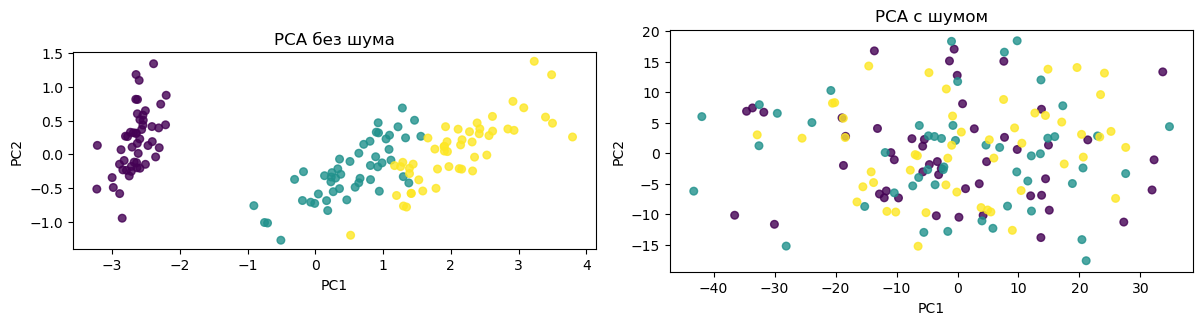

In [71]:
Xp = res["proj"]
Xn = res["noisy_proj"]
n = Xp.rows

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, M, title in zip(axes, [Xp, Xn], ["PCA без шума", "PCA с шумом"]):
    xs = [M.data[i][0] for i in range(n)]
    ys = [M.data[i][1] for i in range(n)]
    ax.scatter(xs, ys, c=y, cmap='viridis', s=30, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

- **PCA без шума**
  - Три метки классов образуют чётко разделённые кластеры вдоль PC1:
    - один «скученный» кластер слева,
    - два более плотных кластера по центру и справа.
  - Разброс по PC2 небольшой (±1.5), что говорит о слабой вариативности во второй компоненте после выделения основной оси.

- **PCA с шумом**
  - Облако точек растянулось по PC1 в диапазон от –40 до +35 и по PC2 до ±20.
  - Цветовые метки полностью перемешались: явных кластеров нет — шум доминирует над сигналом.
  - Структура данных разрушена, оси PCA теперь отражают преимущественно распределение шума.

---
## Выводы:

1. **Эффективность понижения размерности**
   — Без шума две первые компоненты захватывают почти всю вариативность, корректно разделяя классы и почти полностью восстанавливая структуру данных.

2. **Чувствительность к аддитивному шуму**
   — С увеличением уровня гауссова шума доля объяснённой дисперсии падает, MSE растёт пропорционально дисперсии шума, и проекции PCA теряют смысл.

---